# Graph generators

1. Random
2. k-dimentional grid (supporting imperfect sizes)
3. Barabasi
4. Watts-Strogatz
5. Recurrent modular

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

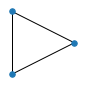

In [5]:
def plot_graph(gdict):
    """Utility: plots a graph from a gdict."""
    G = nx.Graph()
    for node,edges in gdict.items():
        for other in edges:
            G.add_edge(node, other) # Undirected graph, so the order doesn't matter
    nx.draw_kamada_kawai(G, node_size=30)
    return
    
def tinyfig():
    plt.figure(figsize=(1,1))
    
tinyfig()
plot_graph({0:[1,2], 1:[0,2], 2:[1,0]})

In [6]:
def profile(g):
    """Helper function. Returns nV, nE"""
    #print(sorted(set([(i,j) for i,js in g.items() for j in js if i<j])))
    return (len(g), len(set([(i,j) for i,js in g.items() for j in js if i<j])))

profile({0:[1,2], 1:[0,2,4], 2:[1,0,4], 4:[1,2]})

(4, 5)

(9, 12)

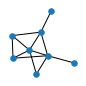

In [11]:
def make_random(n, e=None):
    """Create Erdos graph."""
    if e is None: e = 2*n
    edges = [(i,j) for j in range(n) for i in range(j)]
    edges = [edges[i] for i in np.random.choice(n*(n-1)//2, e, replace=False)]
    g = {i:list(set([j for k,j in edges if k==i] + [k for k,j in edges if j==i])) for i in range(n)}
    return g

tinyfig()
g = make_random(9,12)
plot_graph(g)
profile(g)

(9, 12)

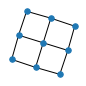

In [26]:
def make_grid(n, e=None, ndim=None):
    """Create a grid-like network. Doesn't guarantee one component :("""
    
    def _intp(a,p):
        """Integer power"""
        if p<=0: return 1
        else: return a*(_intp(a, p-1))
    
    if e is None: e = n*2
    if e > n*(n-1) // 2: e = n*(n-1) // 2
    if ndim is None: 
        ndim = int(2*e/n)  # Rather suboptimal heuristics
    g = {i:[] for i in range(n)}
    width = int(np.round(np.power(n,1/ndim)))
    #print(f"dim: {ndim}")
    e_count = 0
    steps = [_intp(width, idim) for idim in range(ndim+1)]
    for i in range(n):
        for idim in range(ndim):
            if ((i // steps[idim] + 1) % width)  != 0: # On the border, no further link
                j = i + steps[idim]
                if j<n:
                    #print(f"dim {idim}, {(i,j)}, compared to {steps[idim]}")
                    g[i].append(j)
                    g[j].append(i)
                    e_count += 1
                    if e_count == e:
                        return g
    while e_count < e:
        i = (i+1) % n
        j = (max(g.get(i,[i]))+1) % n
        if j!=i and j not in g[i]:
            g[i].append(j)
            g[j].append(i)
            e_count += 1
    return g

tinyfig()
#g = make_grid(9*3, 9*2+12*3, ndim=3)
g = make_grid(9, 12, 2)
plot_graph(g)
profile(g)

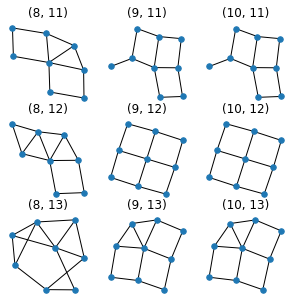

In [30]:
plt.figure(figsize=(5,5))
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,1+i+j*3)
        g = make_grid(8+i, 11+j, 2)
        plot_graph(g)
        plt.title(profile(g))

As we can see, the grid one doesn't really work yet

(9, 12)

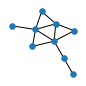

In [15]:
def make_barab(n, e=None):
    """Barabasi preferential attachment"""
    if e is None: e = 2*n
    if e > n*(n-1)/2: e = n*(n-1) // 2
    k = e // n
    graph = {0: []}
    bag = [0]
    e_count = 0
    degree_target = k+1    # Start with placing extra connections
    for i in range(1,n):
        if i not in graph:
            graph[i] = []
        j = 0
        while j < min(i, degree_target):
            to = np.random.choice(bag)
            #print(i, e_count, to, min(i, degree_target), degree_target)
            if to != i and to not in graph[i]:
                graph[i].append(to)
                graph[to].append(i)
                bag += [i, to]
                j += 1
                e_count += 1
        if i<n-1 and (e-e_count) / (n-i-1) == k:
            degree_target = k
    return graph

g = make_barab(9, 12)
tinyfig()
plot_graph(g)
profile(g)

Description for a Watts-Strogatz model: https://en.wikipedia.org/wiki/Watts%E2%80%93Strogatz_model

(9, 12)

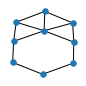

In [94]:
def make_ws(n, e=None, beta=0.3):
    """Makes a Watts-Strogatz network."""
    if e is None: e = n*2
    if e > n*(n-1)/2: 
        e = n*(n-1) // 2
    k = (e // n)*2          # Average degree, rounded down, and forced to be even
    n_group1 = e-(k*n // 2)  # Number of elements with k+2 degree
    g = {i:[] for i in range(n)}
    for i in range(n):
        k1 = k // 2
        if i < n_group1:
            jlist = range(i-k1-1, i+k1+1)
        else:
            jlist = range(i-k1, i+k1+1)
        for j in jlist:
            jp = j % n
            if (jp) ==i:
                continue
            if jp not in g[i]: g[i].append(jp)
            if i not in g[jp]: g[jp].append(i)
    
    for i in range(n): # Rewire something for each node
        js = [j for j in g[i] if j>i] # Those to the right are to be rewired
        for j in js:
            if np.random.uniform()<beta: # Coin toss
                g[i].remove(j)      # Unwire
                k = i               # Set to a deliberately bad choice (self)
                while k==i or k==j or (k in g[i]): # Draw while unhappy (self, old, or existing)
                    k = np.random.randint(n)
                g[i].append(k)
                g[k].append(i)
    return g

#g = make_ws(9, 12, 0.2)
g = make_ws(9, 12, 0.2)
tinyfig()
plot_graph(g)
profile(g)

(12, 21)

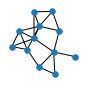

In [25]:
def make_recurrent(n=10):
    """Recursive graph creator. The parameter is the number of nodes"""
    def build_edges(s):
        """Splits the set s in 2 parts randomly, calls itself on parts, then links them."""
        if len(s)<2:
            return []
        s1 = [s[0]] + [e for e in s[1:-1] if np.random.uniform()<0.5]
        s2 = [e for e in s if e not in s1]
        if len(s1)>0 and len(s2)>0: # Neither are empty
            cross_edges = [(np.random.choice(s1), np.random.choice(s2)) for i in range(3)]
            # 3 above is a key parameter that defines density, but I don't know the exact relation ;)
        return build_edges(s1) + build_edges(s2) + cross_edges
    
    def edges_to_gdict(edges):
        """Utility: transforms a graph from edge-form to dict form."""
        g = {}
        for (i,j) in edges:
            g[i] = g.get(i, []) + [j]
            g[j] = g.get(j, []) + [i]
        return g
    
    s = list(range(n))
    edges = build_edges(s)
    return edges_to_gdict(edges)

g = make_recurrent(12)
tinyfig()
plot_graph(g)
#print(g)
profile(g)

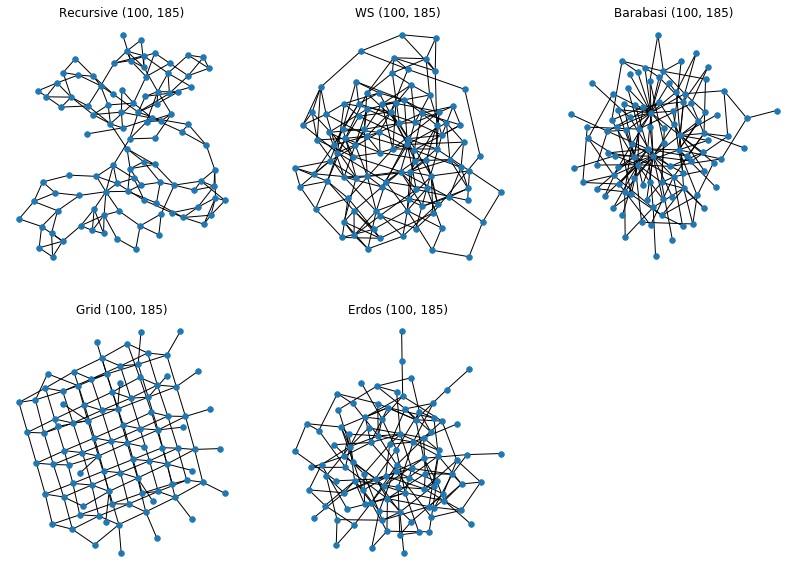

In [111]:
# Gallery
n = 100
plt.figure(figsize=(14,10))
funs = [make_recurrent, make_ws, make_barab, make_grid, make_random]
names = ['Recursive', 'WS', 'Barabasi', 'Grid', 'Erdos']
for i in range(len(funs)):
    plt.subplot(2,3,i+1)
    if i==0:
        g = funs[i](n)      # As recurrent is the only one for which (for now) I don't control N edges,
        n,m = profile(g)    # ... let's just run it first, and make all others follow.
    else:
        g = funs[i](n,m)
    plot_graph(g)
    plt.title(names[i] + ' ' + str(profile(g)))